Twin Delayed DDPG
=================

<font >While DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. <font color=red>**[DDPG problem]** A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function</font>. Twin Delayed DDPG (TD3) is an algorithm that addresses this issue by introducing three critical tricks:

**Trick One: Clipped Double-Q Learning.** TD3 learns *two* Q-functions instead of one (hence "twin"), and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.

**Trick Two: "Delayed" Policy Updates.** TD3 updates the policy (and target networks) less frequently than the Q-function. The paper recommends one policy update for every two Q-function updates.

**Trick Three: Target Policy Smoothing.** TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.

Together, these three tricks result in substantially improved performance over baseline DDPG.

Quick Facts
-----------

* TD3 is an off-policy algorithm.
* TD3 can only be used for environments with continuous action spaces.
* The Spinning Up implementation of TD3 does not support parallelization.

Key Equations
-------------

TD3 concurrently learns two Q-functions, $Q_{\phi_1}$ and $Q_{\phi_2}$, by mean square Bellman error minimization, in almost the same way that DDPG learns its single Q-function. To show exactly how TD3 does this and how it differs from normal DDPG, we'll work from the innermost part of the loss function outwards.

**First: target policy smoothing**. Actions used to form the Q-learning target are based on the target policy, $\mu_{\theta_{\text{targ}}}$, but <font color=red>with clipped noise added on each dimension of the action</font>. After adding the clipped noise, the target action is then clipped to lie in the valid action range (all valid actions, $a$, satisfy $a_{Low} \leq a \leq a_{High}$). The target actions are thus: 

\begin{align*}
    a'(s') = \text{clip}\left(\mu_{\theta_{\text{targ}}}(s') + \text{clip}(\epsilon,-c,c), a_{Low}, a_{High}\right), \;\;\;\;\; \epsilon \sim \mathcal{N}(0, \sigma)
\end{align*}

Target policy smoothing essentially serves as a regularizer for the algorithm. It addresses a particular failure mode that can happen in DDPG: if the Q-function approximator develops an incorrect sharp peak for some actions, the policy will quickly exploit that peak and then have brittle or incorrect behavior. This can be averted by smoothing out the Q-function over similar actions, which target policy smoothing is designed to do. 

**Next: clipped double-Q learning**. Both Q-functions use a single target, calculated using whichever of the two Q-functions gives a smaller target value:

\begin{align*}
    y(r,s',d) = r + \gamma (1 - d) \min_{i=1,2} Q_{\phi_{i, \text{targ}}}(s', a'(s')),
\end{align*}
and then both are learned by regressing to this target:

\begin{align*}
    L(\phi_1, {\mathcal D}) = E_{(s,a,r,s',d) \sim {\mathcal D}}{
        \Bigg( Q_{\phi_1}(s,a) - y(r,s',d) \Bigg)^2
        },
\end{align*}
\begin{align*}
    L(\phi_2, {\mathcal D}) = E_{(s,a,r,s',d) \sim {\mathcal D}}{
        \Bigg( Q_{\phi_2}(s,a) - y(r,s',d) \Bigg)^2
        }.
\end{align*}
Using the smaller Q-value for the target, and regressing towards that, helps fend off overestimation in the Q-function.

**Lastly: the policy is learned just by maximizing $Q_{\phi_1}$**:

\begin{align*}
    \max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi_1}(s, \mu_{\theta}(s)) \right],
\end{align*}
which is pretty much unchanged from DDPG. However, in TD3, the policy is updated less frequently than the Q-functions are. This helps damp the volatility that normally arises in DDPG because of how a policy update changes the target.


Exploration vs. Exploitation
----------------------------

TD3 trains a deterministic policy in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make TD3 policies explore better, we add noise to their actions at training time, typically uncorrelated mean-zero Gaussian noise. To facilitate getting higher-quality training data, you may reduce the scale of the noise over the course of training. (We do not do this in our implementation, and keep noise scale fixed throughout.)

At test time, to see how well the policy exploits what it has learned, we do not add noise to the actions.

**.. admonition:: You Should Know**

Our TD3 implementation uses a trick to improve exploration at the start of training. For a fixed number of steps at the beginning (set with the ``start_steps`` keyword argument), the agent takes actions which are sampled from a uniform random distribution over valid actions. After that, it returns to normal TD3 exploration.


Pseudocode
----------
![title](https://spinningup.openai.com/en/latest/_images/math/b7dfe8fa3a703b9657dcecb624c4457926e0ce8a.svg)


In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
TD3 = pd.read_csv('result_TD3.csv')
DDPG = pd.read_csv("/home/haiyao/Documents/GitHub/6. Youtube-Code-Repository/ReinforcementLearning/PolicyGradient/DDPG/pytorch/lunar-lander/OU_result_DDPG.csv")

Text(0, 0.5, 'average return')

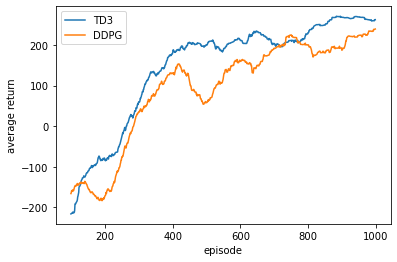

In [8]:
plt.plot(TD3['0'].rolling(100).mean(),label='TD3')
plt.plot(DDPG['0'].rolling(100).mean(),label='DDPG')
plt.legend()
plt.xlabel('episode')
plt.ylabel('average return')